<a href="https://colab.research.google.com/github/gelgel5633/self-study/blob/main/%ED%95%84%EC%82%AC/(1)Toxic_Comment_Classification_Challenge%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 출처
- competition : https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge
- 노트북 링크 : https://www.kaggle.com/code/sbongo/for-beginners-tackling-toxic-using-keras/notebook

이 노트북은 keras LSTM을 사용하여 분류를 해결하기 위한 시도입니다. 이미 이 방식을 사용하여 해결하고 있는 많은 노트북이 있지만, 각 단계에서 무슨 일이 일어나고 있는지에 대한 설명이 충분하지 않다고 생각합니다. 바닐라 Tensorflow를 사용해왔으며 최근에 keras의 멋진 세계를 받아들인 사람으로서 연구와 study에서 얻은 직관을 초급자에게 공유하고 싶습니다  
함께 가시죠.

일반적인 keras library를 import 하겠습니다

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

train, test 데이터를 불러오겠습니다

In [2]:
train = pd.read_csv("/content/drive/MyDrive/transcription_data/Toxic Comment Classification Challenge/train.csv")
test = pd.read_csv("/content/drive/MyDrive/transcription_data/Toxic Comment Classification Challenge/test.csv")

훈련셋과 테스트셋을 살짝 엿보겠습니다

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


일반적인 전처리 단계는 null값을 확인하는 것입니다. 다음 단계로 진행하기 전에 null값을 다른 무언가로 채워야합니다. 만약 null값을 그대로 둔다면 모델링 시간이 늦어질 것입니다

In [4]:
train.isnull().any(), test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

전반적으로 null값을 처리할 필요가 없을 것 같습니다.
데이터 셋에 대하여 처리할 수 있는 많은 전처리 및 피쳐 엔지니어링 단계가 있지만, 이번 노트북에서의 초점은 사전 처리작업에 관한 것이 아니므로 여기서 수행하는 작업은 나머지 단계가 제대로 작동하도록 할 수 있는 최소한의 작업입니다.

위에서 봤던 데이터셋에서 알 수 있듯이 종속변수는 훈련 셋 자체에 있으므로 X와 Y로 분리해야합니다

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

우리가 comment를 신경망의 일부로 LSTM에 공급하는 것이지만, 단어를 있는 그대로 공급할 수는 없습니다.

우리가 해야 할 것입니다.
1. 토큰화 - 문장을 단어로 분해해야합니다. 예를들어 "i love cats and love dogs"라는 문장이 있을 때 ["i", "love", "cats","and","dogs"] 로 나눌 수 있습니다.
2. 단어를 딕셔너리에 넣고 인덱스를 지정합니다. 예를들어 {1:"i",2:"love",3:"cats",4:"and",5:"dogs"}
3. 인덱스 표현 - comment의 index를 시퀀스로 나타내고 LSTM에 공급할 수있습니다. 예를들어 [1,2,3,4,2,5]  

다행히 keras는 더 쉽게 우리의 삶을 만들어주었습니다. 만약 바닐라 텐서플로우를 사용하는경우 자체 사전 구조를 구현하고 인덱싱을 직접 처리해야 합니다. keras에서는 모든 단계를 4줄의 코드로 수행할 수 있습니다. 문장을 토큰화할 때 사전에서 고유한 단어의 수를 정의해야합니다

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

사전에서 각 단어의 발생과 index를 조회할 수 있습니다>

In [7]:
# 긴 출력때문에 comment 하였습니다.
# 단어의 발생빈도를 위해
# tokenizer.word_counts
# 단어의 index를 알기 위해
# tokenizer.word_index

In [8]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

한 가지 문제가 있습니다. 일부 comment는 매우 길고 일부 commnet는 한 단어라면 어덯게 될까요? indexing된 문장이 다음과 같이 보이지 않습니까?  

comment #1 : [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
comment #2 : [1,2]

그래서 일정한 길이를 가진 데이터를 공급해야하지 않겠습니까?  

이것이 우리가 패딩을 사용하는 이유입니다. 부족한 부분을 0으로 채워서 짧은 문장을 다른 문장만큼 길게 만들 수 있습니다. 그러나 긴 것도 짧은 것과 같은 길이로 다듬어야 합니다. 이 경우 최대 길이를 200으로 설정하겠습니다

In [9]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen = maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

설정하기 좋은 maxlen이 무엇인지 어떻게 알 수 있을까요? 너무 짧게 입력하면 유용한 특성을 잃어버릴 것이고 정확도가 떨어질 것입니다. 너무 길게 입력하면 LSTM셀이 더 커져야 합니다  
이를 해결할 방법은 하나의문장에서 단어 수의 분포를 보는 것입니다

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

(array([21439., 27127., 22176., 16223., 12859., 10062.,  7586.,  5991.,
         4731.,  3914.,  3129.,  2820.,  2306.,  1896.,  1647.,  1455.,
         1329.,  1287.,  1013.,   857.,   750.,   799.,   528.,   581.,
          486.,   437.,   407.,   373.,   386.,   292.,   284.,   242.,
          217.,   169.,   156.,   167.,   158.,   133.,   136.,   116.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

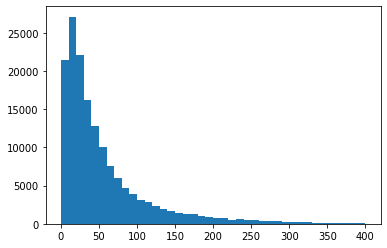

In [11]:
plt.hist(totalNumWords, bins = np.arange(0,410,10))
#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
# 위에는 이렇게 적혀있으나 실제로는
#[0,10,20,30,40,50,60,70,80,90.......... 390,400] 이 되어야함

대부분의 문장 길이는 약 30+ 입니다. maxlen을 50으로 설정할 수 있지만 200으로 설정하겠습니다. 그런 다음 다시 실험하고 최선의 수가 무엇인지 확인할 수 있을 것으로 들립니다

__마침내 모델을 구축하기 시작합니다__  
이것이 우리가 구축하려는 모델의 구조입니다. 시각적으로 생각하고 나중에 디버그하는 데 도움이 되도록 모델의 각 레이어 치수를 나열하는 것은 나중에도 좋은 방법입니다

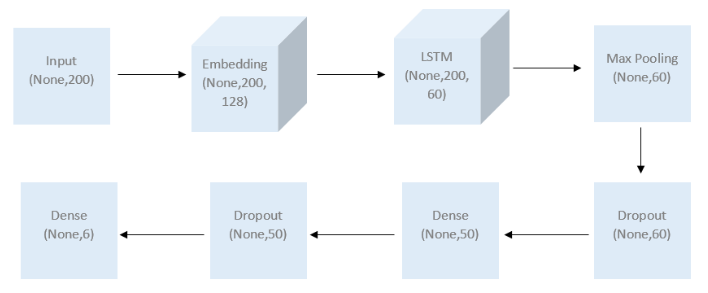

앞서 언급했듯이 네트워크에 대한 입력은 인코딩된 문장의 목록입니다. 차원이 200인 문장 리스트를 인풋레이어에 정의하겠습니다

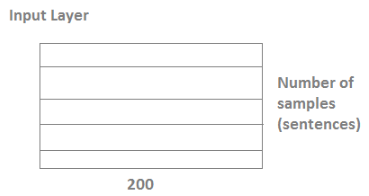

쉼표 뒤에 빈 공간을 표시하면 keras가 숫자를 자동으로 유추하도록 지시합니다.

In [12]:
inp = Input(shape = (maxlen,))

다음으로 그것을(input) embedding layer에 전달합니다. 문장에서 주변 단어들의 벡터 거리에 단어를 투영합니다. 원-핫 인코딩을 사용하여 문장의 단어를 표현하는 경우 모델 크기와 큰 차원을 가지게 되는데, 임베딩을 사용하면 이를 줄일 수 있습니다. embedding 레이어의 출력은 벡터공간에 있는 좌표 목록입니다.   
예를 들어 (-81.012) "고양이", (-80.012) "개" 또한 이러한 좌표의 거리를 사용하여 관련성과 문맥을 감지할 수 있습니다.
임베딩은 매우 깊은 주제이며 관심이 있는 경우 다음과 같은 포괄적인 가이드를 참조하세요  
링크 : https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

벡터 공간의 크기를 정의할 필요가 있습니다. 위에서 언급했듯, 고유 단어의 수(max_features)를 정의해야 합니다. 다시 말하지만, 임베딩 크기는 조정하고 실험할 수 있는 매개변수입니다.

In [13]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

임베딩 레이어는 (None, 200, 128)의 3차원 텐서를 출력합니다. 이는 문장의 배열(None은 크기)이며, 각 단어(200)에 대해 임베딩 벡터 공간에 128개의 좌표 배열이 있습니다.

우리는 이 Tensor를 LSTM에 공급합니다. 차원이 60인 출력을 생성하도록 LSTM을 설정하고 unroll된 전체 시퀀스를 반환하기를 원합니다
-> unroll을 찾아보니 rnn을 각 타임스텝별로 풀어놓은 것을 rnn unroll 이라고 합니다  


  

아시다시피 LSTM 혹은 RNN은 이전 네트워크의 출력을 현재 네트워크의 입력으로 재귀적으로 공급하여 작동하며 X번의 재귀 이후 최종 출력을 가져옵니다.   

사용 사례에 따라 unroll하기를 원하거나 다음레이어로 전달할 결과로 사용하기를 원할 것입니다. 우리가 사용할 것입니다

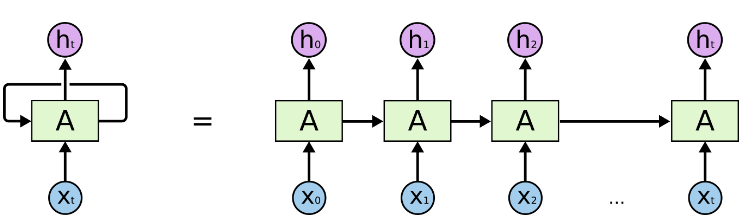

위의 그림에서 LSTM은 마지막h까지 h0,h1,h2를 전달합니다  
LSTM 계층을 정의하는 짧은 코드에서 요구되는 입력 차원을 놓치기 쉽습니다. LSTM의 텐서는[batch_size, timpe_steps, number_of_inputs]입니다. batch_size는 배치의 샘플 수이고, time_steps는 각 입력에 대해 실행되는 재귀 횟수입니다. 또는 위의 그림에서 "A"의 갯수로 나타낼 수 있습니다. 마지막으로 number_of_inputs는 위의 LSTM에 전달하는 변수의 갯수(이 경우 각 문장의 단어 갯수) 입니다.  

(None, 200, 128)의 3차원 텐서를 LSTM레이어로 출력하는 이전 임베딩 레이어의 출력을 사용할 수 있습니다. 샘플을 살펴보고, LSTM을 200번 재귀적으로 실행하고 매번 좌표를 전달합니다. 그리고 우리는 펼쳐진 버전을 원하기 때문에 (None, 200, 60)의 텐서를 받게 됩니다. 60은 우리가 정의한 출력 차원입니다

In [14]:
x = LSTM(60, return_sequences = True, name = "lstm_layer")(x)

출력을 일반 레이어에 전달하기 전에 3D 텐서를 2D 텐서로 재구성해야 합니다. 중요한 데이터를 버리지 않도록 신중하게 재구성하고 결과 데이터가 원본 데이터를 잘 표현(대표)하기를 바랍니다.     

따라서 이미지의 데이터 차원을 줄이기 위해 CNN에서 전통적으로 사용되는 Global Max Pooling 레이어를 사용합니다. 간단히말해서, 데이터의 각 부분을 살펴보고 각 부분의 최댓값을 취합니다. 이러한 최댓값의 모음은 우리가 사용할 수 있는 축소된 데이터의 새로운 집합이 될 것입니다  

다른 캐글 커널에서 볼 수 있듯이 풀링레이어의 다양한 변형(평균, 최댓값 등)이 차원 축소에 사용되며 다른 결과를 얻을 수도 있습니다. 시도해보세요.  

풀링의 세부적인 내용을 알고싶다면 링크를 클릭하세요   
링크 : https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/

In [15]:
x = GlobalMaxPool1D()(x)

우리가 2D텐서를 가지고 있는데, dropout 레이어에 전달합니다. dropout 레이어는 무차별적으로 node를 비활성화하는데, 더 나은 일반화를 도출할 수 있습니다.  
drop out의 비율은 10%로 하겠습니다

In [16]:
x = Dropout(0.1)(x)

drop out 레이어 이후에 출력을 dense층에 연결하고 출력은 relu 활성화함수를 통과합니다. 요약하자면  
__활성화함수((input x weights) + bias)__  

가중치, 편향, 활성화함수가 한 줄에 설정되었습니다. dense레이어를 정의하여 50의 출력 차원을 생성했습니다

In [17]:
x = Dense(50, activation = "relu")(x)

다시 drop out 레이어에 통과시켜주겠습니다

In [18]:
x = Dropout(0.1)(x)

최종적으로 우리는 시그모이드 레이어에 출력을 전달합니다. 시그모이드가 사용되는 이유는 6개의 label에 대해 이진분류를 수행하는데 출력을 0과 1 사이에서 압축시킵니다

In [19]:
x  =Dense(6, activation = "sigmoid")(x)

거의 끝났습니다. 입력, 출력을 정의하고 학습 프로세스를 구성하는 것만 남았습니다. 이진분류를 다루기 때문에 adam 옵티마이저를 사용하여 손실 함수를 최적화하도록 모델을 설정하고 손실함수를 이진 크로스 엔트로피로 정의합니다. 학습률은 기본값을 0.001로 설정합니다

In [20]:
model = Model(inputs = inp, outputs = x)
model.compile(loss= "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

우리의 모델을 테스트할 시간입니다. 각 배치에 32개의 패딩되고 인덱싱된 list를 제공하고 데이터의 10%를 검증셋으로 분할합니다. 이 검증 세트는 각 배치에 대해 모델이 과적합 되었는지 여부를 평가하는 데 사용됩니다. 이 모델은 2epoch 동안에 실행됩니다. 다음은 실험할 수 있는 몇 가지 조정 가능한 매개변수로, model을 손상시키지 않고 정확도를 높일 수 있는지 확인합니다

In [21]:
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

Epoch 1/2
4488/4488 [==============================] - 81s 16ms/step - loss: 0.0686 - accuracy: 0.9488 - val_loss: 0.0493 - val_accuracy: 0.9939
Epoch 2/2
4488/4488 [==============================] - 56s 12ms/step - loss: 0.0449 - accuracy: 0.9893 - val_loss: 0.0474 - val_accuracy: 0.9932


정확도는 기본 시도에 꽤 괜찮은 것 같습니다. 정확도를 상승시키기 위해 할 수 있는 일이 많으므로(아래 TODO를 참조) 직접 실험해보세요

__추가적인 팁__  
1. 특히 차원과 관련된 오류를 반환할 때 model.summary()를 실행하는 것이 좋습니다. 진단에 매우 유용한 모든 계층 출력을 나열하기 때문입니다.

In [21]:
model.summary()

2. 더 많은 레이어를 추가하고 더 멋진 변형을 수행하면서 출력이 예상한 대로 수행되는지 확인하는 것이 좋습니다. 다음을 통해 특정 레이어의 출력을 표시할 수 있습니다.

In [22]:
from keras import backend as K

# sequential 모델
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape
# 실제 데이터에 대한 레이어 출력

(1, 200, 60)

개인적으로 저는(원본 작성자가) 케라스가 시간과 행렬에 대한 올바른 차원을 정의하는 번거로운 작업을 덜어준다는 것을 알았습니다. 절약된 시간은 다양한 모델 변형 실험 등과 같은 유익한 작업에 사용할 수 있습니다. 그러나 많은 변수와 프로세스가 딥러닝 초보자가 내부에서 무슨 일이 일어나고 있는지 깨닫지 못할 수 있는 방식으로 초기화된다는 것을 알았습니다. 복잡한 세부 사항이 많기 때문에 초보자가 이 블랙박스를 열도록 권장합니다. 그러면 딥러닝에 대한 풍부한 지식을 보상으로 받을 수 있습니다.   
누군가 이 짧은 가이드를 유용하게 사용할 수 있기를 바랍니다. 그러한 가이드를 더 보고싶다면 이 커널을 추천하여 저를 지원해주세요. 읽어주셔서 감사합니다.

__TODO__  
1. 정확도 상승과 노력의 이점을 가지기 위해 사전학습된 모델을 사용하세요
2. 하이퍼파라미터를 조절하세요
3. 모델 훈련시 조기종료를 도입하세요
4. 다른 구조로 실험하세요